In [13]:
import gc
import torch
import time

from pydantic import BaseModel, Field
from typing import Literal, List, Dict, Any, Tuple
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_classic.retrievers import ContextualCompressionRetriever
from langchain_classic.retrievers.document_compressors import CrossEncoderReranker
from langgraph.graph import END, StateGraph

In [2]:
loader = PyPDFLoader('./data/투자설명서.pdf')

In [3]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})

In [4]:
docs = loader.load()
full_text = '\n\n'.join(doc.page_content for doc in docs)
text_splitter = SemanticChunker(embeddings=embeddings)
docs = text_splitter.create_documents([full_text])
for doc in docs:
    doc.metadata['source'] = '투자설명서.pdf'
print(len(docs))

243


In [5]:
gc.collect()
torch.cuda.empty_cache()
time.sleep(3)

In [6]:
faiss_store = FAISS.from_documents(docs, embedding=embeddings)
persist_dir = './data/faiss_index_dense'
faiss_store.save_local(persist_dir)

In [7]:
vectorstore = FAISS.load_local(persist_dir, embeddings=embeddings, allow_dangerous_deserialization=True)
vectorstore

In [8]:
gc.collect()
torch.cuda.empty_cache()
time.sleep(3)

In [9]:
llm_eval = ChatOpenAI(model='gpt-5-nano', temperature=0)
llm_gen = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [10]:
cross_encoder = HuggingFaceCrossEncoder(model_name='Dongjin-kr/ko-reranker', model_kwargs={'device':'cuda'})
reranker = CrossEncoderReranker(model=cross_encoder, top_n=3)
base_retriever = vectorstore.as_retriever()

In [11]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=reranker,
    base_retriever=base_retriever
)

In [14]:
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[Document]
    retry_count: int

In [15]:
def retrieve(state):
    print('---Retrieve---')
    
    question = state['question']
    documents = compression_retriever.invoke(question)

    return {'documents':documents, 'question':question, 'retry_count':0}

In [16]:
def grade_documents(state):
    print('---Check Relevance---')

    question = state['question']
    documents = state['documents']

    class Grade(BaseModel):
        binary_score: str = Field(description='문서가 질문과 관련이 있으면 "yes", 아니면 "no"')
    
    structured_llm_grader = llm_eval.with_structured_output(Grade)

    system = '''당신은 제공된 연관 문서가 주어진 질문과 관련이 있는지, 그리고 질문에 답하는 데 유용한 정보를 제공하는지 판단하는 것입니다.
    철저하게 검증하여 문서가 질문의 키워드나 의미를 포함하고 있다면 "yes"를, 아니라면 "no"를 출력하세요.'''
    grade_prompt = ChatPromptTemplate.from_messages(
        [('system', system), ('human', '질문: {question}\n\n문서: {document}')]
    )
    retrieval_grader = grade_prompt | structured_llm_grader

    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke({'question':question, 'document':doc.page_content})
        if score.binary_score == 'yes':
            print(f' -- 문서 채택: (관련성 있음)')
            filtered_docs.append(doc)
        else:
            print(f' -- 문서 기각: (관련성 없음)')
    
    return {'documents':filtered_docs, 'question':question}

In [17]:
def transform_query(state):
    print('---Transform Query---')

    question = state['question']
    documents = state['documents']
    retry_count = state.get('retry_count', 0) + 1

    system = '''당신은 사용자의 질문을 검색에 더 최적화된 형태로 다듬는 전문가입니다.
    원래 질문의 의도를 유지하면서, 더 좋은 문서를 찾을 수 있도록 질문을 수정하세요.'''
    retry_prompt = ChatPromptTemplate.from_messages(
        [('system', system), ('human', '원본 질문: {question}')]
    )
    question_rewriter = retry_prompt | llm_eval | StrOutputParser()

    better_question = question_rewriter.invoke({'question':question})

    print(f' -- 수정된 질문: {better_question}')

    return {'documents':documents, 'question':better_question, 'retry_count':retry_count}

In [18]:
def generate(state):
    print('---Generate---')

    question = state['question']
    documents = state['documents']

    prompt = ChatPromptTemplate.from_template(
        '''다음 문서들을 바탕으로 질문에 답변하세요.
        문서: {context}
        질문: {question}
        답변:'''
    )

    context = '\n\n'.join(doc.page_content for doc in documents)
    rag_chain = prompt | llm_gen | StrOutputParser()

    generation = rag_chain.invoke({'context':context, 'question':question})

    return {'documents':documents, 'question':question, 'generation':generation}

In [19]:
def decide_to_generate(state):
    filtered_documents = state['documents']
    retry_count = state.get('retry_count', 0)

    if not filtered_documents:
        if retry_count > 3:
            print('---Decision: Max Retried Reached -> END---')
            return 'generate'
        print('---Decision: No Rerevant Docs -> Transform query---')
        return 'transform_query'
    else:
        print('---Decision: Docs Found -> Generate---')
        return 'generate'

In [21]:
workflow = StateGraph(GraphState)

workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('transform_query', transform_query)
workflow.add_node('generate', generate)

workflow.set_entry_point('retrieve')

workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {'transform_query':'transform_query', 'generate':'generate'}
)
workflow.add_edge('transform_query', 'retrieve')
workflow.add_edge('generate', END)

app = workflow.compile()

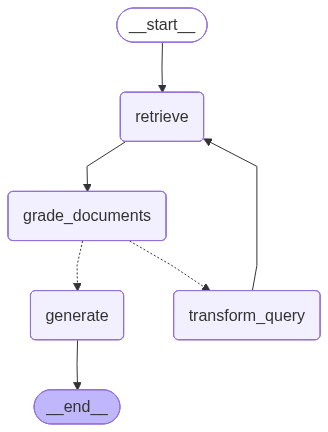

---Retrieve---
---Check Relevance---
 -- 문서 채택: (관련성 있음)
 -- 문서 채택: (관련성 있음)
 -- 문서 채택: (관련성 있음)
---Decision: Docs Found -> Generate---
---Generate---

--- 최종 답변 ---
이 회사의 바이오 의약품 라이센스 아웃 수익 구조는 다음과 같습니다:

1. **총 계약금액**: 
   - BVAC-Neo와 관련하여 (주)LG화학과 체결한 계약의 총 계약금액은 183,500백만원입니다.
   - BVAC-C와 관련하여 NeoImmuneTech와 체결한 계약의 총 계약금액은 567,000달러입니다.

2. **수취금액**:
   - BVAC-Neo의 경우, 계약 체결 시 수취한 계약금(Upfront Payment)은 1,000백만원입니다.
   - BVAC-C의 경우, 계약금(Upfront Payment)은 567,000달러입니다.

3. **마일스톤**:
   - BVAC-Neo의 경우, 개발, 인허가 및 판매 등 단계별로 최대 182,500백만원의 마일스톤 수익을 받을 예정입니다.

4. **로열티**:
   - BVAC-Neo의 경우, 순매출액에 따라 별도로 로열티를 수취할 예정입니다.

이러한 수익 구조는 계약의 진행 상황에 따라 달라질 수 있으며, 임상시험, 허가, 규제 승인 미실현 등으로 인해 계약이 종료될 경우 수익에 영향을 미칠 수 있습니다.


In [22]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

question = '이 회사의 바이오 의약품 라이센스 아웃 수익을 알려줘.'
inputs = {'question':question}
for output in app.stream(inputs):
    pass

print('\n--- 최종 답변 ---')
print(output['generate']['generation'])